In [1]:
from PIL import Image

import numpy as np
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg19

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading class

In [2]:
class SRDataset(Dataset):
    def __init__(self, root_dir, lowres_transform, highres_transform, both_transform):
        super(SRDataset, self).__init__()
        
        self.root_dir = root_dir
        
        self.lowres_transform = lowres_transform
        self.highres_transform = highres_transform
        self.both_transform = both_transform
        
        self.list_of_files = os.listdir(os.path.join(root_dir))

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.root_dir, self.list_of_files[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.both_transform(image=image)['image']
        low_res_image = self.lowres_transform(image=image)['image']
        high_res_image = self.highres_transform(image=image)['image']
        
        return low_res_image, high_res_image

## Modeling

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()
        
    def forward(self, x):
        return self.act(self.cnn(x))

In [4]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_channels, in_channels, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [5]:
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()
        
        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels*i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <=3 else False,
                )
            )
        
    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        
        return self.residual_beta * out + x

In [6]:
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])
    
    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels),
            UpsampleBlock(num_channels)
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=True)
        )
        
    def forward(self, x):
        initial = self.initial(x)
        out = self.residuals(initial)
        out = self.conv(out) + initial
        out = self.upsamples(out)
        out = self.final(out)
        return out

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=(64, 64, 128, 128, 256, 256, 512, 512)):
        super().__init__()

        self.in_channels = in_channels
        self.features = list(features)

        blocks = []

        for idx, feature in enumerate(self.features):
            blocks.append(
                ConvBlock(
                    in_channels=in_channels,
                    out_channels=feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True
                )
            )
            in_channels=feature

        self.blocks = nn.Sequential(*blocks)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(in_features=512*6*6, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.blocks(x)
        out = self.classifier(features)
        # out = self.sigmoid(out)
        return out

In [9]:
def init_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale
        
        

In [10]:
def test_size():
    gen = Generator()
    disc = Discriminator()
    low_res = 24
    x = torch.randn((5, 3, low_res, low_res))
    gen_out = gen(x)
    disc_out = disc(x)
    
    print(gen_out.shape)
    print(disc_out.shape)

In [11]:
test_size()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


## Defining loss functions

In [12]:
class VGGLoss(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        vgg_input_features = self.vgg(output)
        vgg_target_features = self.vgg(target)
        loss = self.loss(vgg_input_features, vgg_target_features)

        return loss

In [13]:
class ESRGANLoss(nn.Module):
    def __init__(self, l1_weight=1e-2, vgg_weight=1, device='cpu'):
        super().__init__()
        
        self.vgg_criterion = VGGLoss(device)
        self.l1_criterion = nn.L1Loss().to(device)
        self.l1_weight = l1_weight
        
    def forward(self, output, target):
        vgg_loss = self.vgg_criterion(output, target)
        l1_loss = self.l1_criterion(output, target)
        
        loss = vgg_loss + self.l1_weight * l1_loss
        return loss

In [14]:
def gradient_penalty(critic, real, fake, device):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

In [15]:
device = "cpu" if torch.cuda.is_available() else "cpu"

In [16]:
print(device)

cpu


## Defining config and hyper params

In [18]:
lr = 1e-4
num_epochs = 5
batch_size = 4
lambda_gp = 10
num_workers = 0

In [20]:
high_res = 1024
low_res = high_res // 4
num_channels = 3

In [21]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

## Defining data transformations 

In [22]:
highres_transform = A.Compose(
    [
        A.Resize(width=high_res, height=high_res),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Resize(width=low_res, height=low_res, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0 , 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

both_transforms = A.Compose(
    [
        A.RandomCrop(width=high_res, height=high_res),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

In [23]:
train_dataset = SRDataset(
    root_dir = r'C:\Users\dell\Desktop\ESRGAN\data\DIV2K_train_HR',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    both_transform = both_transforms
)

print(len(train_dataset))

val_dataset = SRDataset(
    root_dir = r'C:\Users\dell\Desktop\ESRGAN\data\DIV2K_valid_HR',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    both_transform = both_transforms
)

print(len(val_dataset))

800
100


## Loading the data

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

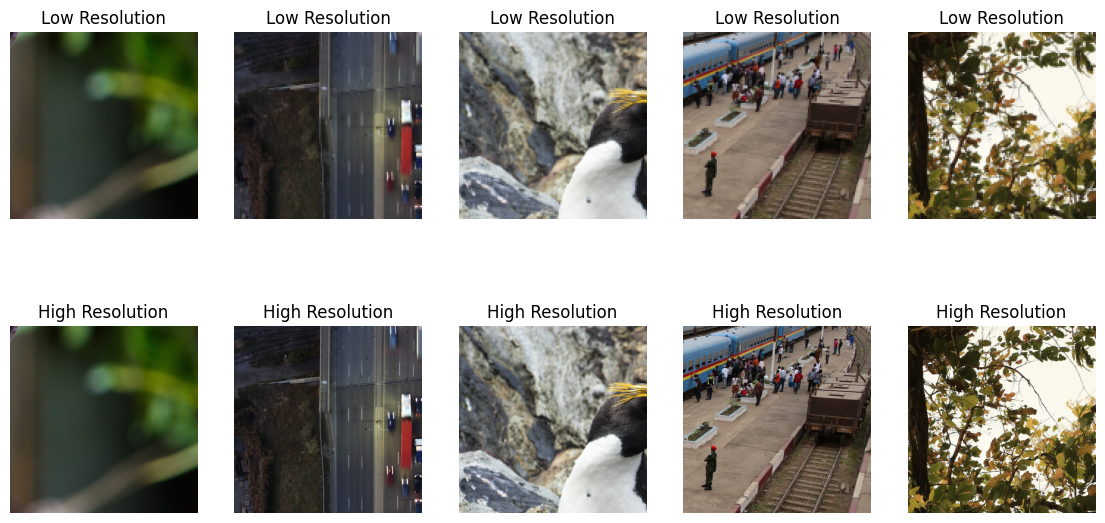

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7))

for i, (low_res, high_res) in enumerate(val_loader):
    if i >= 5:
        plt.show()
        break

    axes[0, i].imshow(low_res[0].permute(1, 2, 0))
    axes[0, i].set_title("Low Resolution")
    axes[0, i].axis('off')

    axes[1, i].imshow(high_res[0].permute(1, 2, 0))
    axes[1, i].set_title("High Resolution")
    axes[1, i].axis('off')
    
    # Save low-resolution image
    plt.imsave(f'C:/Users/dell/Desktop/ESRGAN/images/low_res/low_res_{i}.png', low_res[0].permute(1, 2, 0).numpy())

    # Save high-resolution image
    plt.imsave(f'C:/Users/dell/Desktop/ESRGAN/images/high_res/high_res_{i}.png', high_res[0].permute(1, 2, 0).numpy())

In [25]:
generator = Generator(in_channels=num_channels, num_blocks=1).to(device)
discriminator = Discriminator(in_channels=num_channels).to(device)
init_weights(generator)
model = {
    'discriminator': discriminator,
    'generator': generator
}

In [26]:
optimizer_generator = torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_discriminator = torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer = {
    'discriminator': optimizer_discriminator,
    'generator': optimizer_generator
}

In [27]:
criterion_generator = ESRGANLoss(l1_weight=1e-2,device=device)
criterion_discriminator = nn.BCELoss().to(device)
criterion = {
    'discriminator': criterion_discriminator,
    'generator': criterion_generator
}

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
generator_scaler = torch.cuda.amp.GradScaler()
discriminator_scaler = torch.cuda.amp.GradScaler()

## Traning 

In [30]:
def train(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    tb_step,

    num_epochs=10,
    device='cpu',
    checkpoint_path=None  # Path to the checkpoint file
):
    # Load checkpoint if provided
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        gen.load_state_dict(checkpoint['gen_state_dict'])
        opt_gen.load_state_dict(checkpoint['opt_gen_state_dict'])
        disc.load_state_dict(checkpoint['disc_state_dict'])
        opt_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
        tb_step = checkpoint['tb_step']
        iteration_start = checkpoint['iteration'] + 1
        print("checkpoint loaded sucessfully")
    else:
        iteration_start = 0

    for iteration in range(iteration_start, num_epochs):
        loop = tqdm(loader, leave=True)

        for idx, (low_res, high_res) in enumerate(loop):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            with torch.cuda.amp.autocast():
                fake = gen(low_res)
                critic_real = disc(high_res)
                critic_fake = disc(fake.detach())
                gp = gradient_penalty(disc, high_res, fake, device=device)
                loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake))
                    + lambda_gp * gp
                )

            opt_disc.zero_grad()
            d_scaler.scale(loss_critic).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

            # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            with torch.cuda.amp.autocast():
                l1_loss = 1e-2 * l1(fake, high_res)
                adversarial_loss = 5e-3 * -torch.mean(disc(fake))
                loss_for_vgg = vgg_loss(fake, high_res)
                gen_loss = l1_loss + loss_for_vgg + adversarial_loss

            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            tb_step += 1

            loop.set_postfix(
                epoch=str(iteration)+"/"+str(num_epochs),
                gp=gp.item(),
                critic=loss_critic.item(),
                l1=l1_loss.item(),
                vgg=loss_for_vgg.item(),
                adversarial=adversarial_loss.item(),
            )

        # Save checkpoint every 50 epochs
        if iteration == 200 or iteration == 220:
            checkpoint_name = fr'checkpoint_epoch_{iteration}.pth'
            checkpoint_path = fr'C:\Users\dell\Desktop\ESRGAN\models\{checkpoint_name}'
            torch.save({
                'gen_state_dict': gen.state_dict(),
                'opt_gen_state_dict': opt_gen.state_dict(),
                'disc_state_dict': disc.state_dict(),
                'opt_disc_state_dict': opt_disc.state_dict(),
                'tb_step': tb_step,
                'iteration': iteration
            }, checkpoint_path)





In [42]:
tb_step = train(
    loader = train_loader,
    disc = model["discriminator"],
    gen = model['generator'],
    opt_gen = optimizer['generator'],
    opt_disc = optimizer['discriminator'],
    l1 = nn.L1Loss(),
    vgg_loss = VGGLoss(device),
    g_scaler = generator_scaler,
    d_scaler = discriminator_scaler,
    tb_step = 0,
    device = device,
    num_epochs = 220,
    checkpoint_path=fr"C:\Users\dell\Desktop\ESRGAN\checkpoint_epoch_185.pth"
)

checkpoint loaded sucessfully


  7%|▋         | 14/200 [01:47<23:46,  7.67s/it, adversarial=-0.0572, critic=-26.5, epoch=186/220, gp=0.945, l1=0.000475, vgg=0.992]


KeyboardInterrupt: 

## Testing checkpoint

In [29]:
import os
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image

# Define the path to the checkpoint file
checkpoint_path = r"C:\Users\dell\Desktop\ESRGAN\checkpoint_epoch_330.pth"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Extract generator state dictionary from the checkpoint
gen_state_dict = checkpoint['gen_state_dict']

# Instantiate the generator using the defined class
# Assuming you have defined the Generator class with 'num_channels' and 'num_blocks'
gen = Generator(in_channels=num_channels, num_blocks=1)
gen.load_state_dict(gen_state_dict)
gen.eval()

# Define transformations to convert tensors to PIL images
to_pil = transforms.ToPILImage()

# Define directories to load low-res images and save high-res images
low_res_dir = r"C:\Users\dell\Desktop\ESRGAN\images\low_res"
high_res_dir = r"C:\Users\dell\Desktop\ESRGAN\images\high_res"

# Ensure the directories exist, create them if not
os.makedirs(low_res_dir, exist_ok=True)
os.makedirs(high_res_dir, exist_ok=True)

# List all low-res image files in the directory
low_res_files = [f for f in os.listdir(low_res_dir) if os.path.isfile(os.path.join(low_res_dir, f))]

for i, filename in enumerate(tqdm(low_res_files)):
    # Load low-res image
    low_res_path = os.path.join(low_res_dir, filename)
    low_res_img = Image.open(low_res_path).convert('RGB')

    # Convert low-res image to tensor
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Assuming the low-res image size is 64x64
        transforms.ToTensor()
    ])
    low_res_tensor = transform(low_res_img).unsqueeze(0)

    # Generate high-res image from low-res input
    with torch.no_grad():
        fake_high_res = gen(low_res_tensor)
    fake_high_res_pil = to_pil(fake_high_res[0].detach().cpu())

    # Save high-res image
    high_res_save_path = os.path.join(high_res_dir, f"high_res_image_{i}.png")
    fake_high_res_pil.save(high_res_save_path)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dell\\Desktop\\ESRGAN\\checkpoint_epoch_330.pth'

In [34]:
# Load the generator from the provided checkpoint file
checkpoint_path = r"C:\Users\dell\Downloads\checkpoint_epoch_622.pth"  # Path to the checkpoint file
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Load the checkpoint

# Extract generator state dictionary from the checkpoint
gen_state_dict = checkpoint['gen_state_dict']

# Instantiate the generator using the defined class
gen = Generator(in_channels=num_channels, num_blocks=1)  # Instantiate the generator using the provided class
gen.load_state_dict(gen_state_dict, strict=False)  # Load the state dictionary into the generator
gen.eval()  # Set the generator to evaluation mode

# Define transformations to convert tensors to PIL images
to_pil = transforms.ToPILImage()

# Iterate through the validation loader to process images
for i, (low_res, high_res) in enumerate(tqdm(val_loader)):
    if i >= 1:
        break

    # Convert low-res image tensor to a PIL image
    low_res_pil = to_pil(low_res[0])

    # Save low-res image to drive
    low_res_save_path = r"C:\Users\dell\Desktop\ESRGAN\images\low_res.png"  # Define the path where you want to save the low-res image
    low_res_pil.save(low_res_save_path)  # Save the PIL image

    # Generate high-res image from low-res input
    fake_high_res = gen(low_res)
    fake_high_res_pil = to_pil(fake_high_res[0].detach().cpu())

    # Save high-res image to drive
    high_res_save_path = r"C:\Users\dell\Desktop\ESRGAN\images\high_res.png"  # Define the path where you want to save the high-res image
    fake_high_res_pil.save(high_res_save_path)  # Save the PIL image

  1%|          | 1/100 [00:02<03:22,  2.04s/it]
